In [2]:
"""
Create fuel load and firep percentage TIFs, then regrid both these TIFs and ERA5 NetCDF
data to the same perfectly aligned 0.1° grid for Portugal.

This ensures:
1. All data uses the exact same 0.1° grid
2. Perfect pixel alignment between weather and fuel/firep data
3. No aliasing issues from shifting grids
"""
import numpy as np
import xarray as xr
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds
from rasterio.features import rasterize
import geopandas as gpd
from pathlib import Path
from typing import Dict, Tuple
import warnings
import glob
import os

warnings.filterwarnings('ignore')

In [3]:
import geopandas as gpd
from shapely.geometry import Polygon

resolution = 0.1
minx, miny, maxx, maxy = -10.0, 37.0, -6.0, 43.0

cols = int((maxx - minx) / resolution)
rows = int((maxy - miny) / resolution)

polygons = []
ids = []
lons = []
lats = []

for i in range(rows):
    for j in range(cols):
        # Ajusta para que o centro da célula seja em múltiplos inteiros ou decimais de 0.1
        lon_center = minx + j * resolution
        lat_center = miny + i * resolution

        # Canto inferior esquerdo
        xmin = lon_center - resolution/2
        xmax = lon_center + resolution/2
        ymin = lat_center - resolution/2
        ymax = lat_center + resolution/2

        poly = Polygon([(xmin, ymin), 
                        (xmax, ymin),
                        (xmax, ymax), 
                        (xmin, ymax)])
        polygons.append(poly)
        ids.append(f"{i}_{j}")
        lons.append(lon_center)
        lats.append(lat_center)

gdf = gpd.GeoDataFrame(
    {
        "cell_id": ids,
        "lon": lons,  # centro da célula
        "lat": lats,  # centro da célula
    },
    geometry=polygons,
    crs="EPSG:4326"
)

print(gdf.head())

  cell_id   lon   lat                                           geometry
0     0_0 -10.0  37.0  POLYGON ((-10.05 36.95, -9.95 36.95, -9.95 37....
1     0_1  -9.9  37.0  POLYGON ((-9.95 36.95, -9.85 36.95, -9.85 37.0...
2     0_2  -9.8  37.0  POLYGON ((-9.85 36.95, -9.75 36.95, -9.75 37.0...
3     0_3  -9.7  37.0  POLYGON ((-9.75 36.95, -9.65 36.95, -9.65 37.0...
4     0_4  -9.6  37.0  POLYGON ((-9.65 36.95, -9.55 36.95, -9.55 37.0...


In [59]:
# ============================================================================
# FUEL LOAD TABLE (from notebook)
# ============================================================================
FUEL_LOAD_TABLE = {
    4:   34.67,   # Mato Alto com continuidade h e v
    98:  0.00,    # sem combustível
    221: 15.49,   # M-CAD
    222: 15.04,   # M-ESC
    223: 16.69,   # M-EUC
    227: 17.10,   # M-PIN
    231:  3.55,   # V-Ha
    232:  1.50,   # V-Hb
    233: 26.50,   # V-MAa
    234: 14.00,   # V-MAb
    235:  9.00,   # V-MH
    236: 23.00,   # V-MMa
    237: 11.50    # V-MMb
}

In [60]:
base_folder = r"..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd"

subfolder_tiffs = {}

for root, dirs, files in os.walk(base_folder):

    # procurar apenas os tif da pasta atual
    tif_files = sorted(glob.glob(os.path.join(root, "*.tif")))

    if tif_files:
        subfolder_name = os.path.basename(root)
        subfolder_tiffs[subfolder_name] = tif_files

for k, v in subfolder_tiffs.items():
    print(f"{k}:")
    for f in v:
        print("   ", f)


2015:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2015\fuelmap.tif
2016:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2016\fuelmap.tif
2017:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2017\fuelmap.tif
2018:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2018\fuelmap.tif
2019:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2019\fuelmap.tif
2020:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2020\fuelmap.tif
2021:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2021\fuelmap.tif
2022:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2022\fuelmap.tif
2023:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2023\fuelmap.tif
2024:
    ..\..\..\..\Data\Interim\GIS_data\fuel_models\100m\portugal\PT-FireSprd\2024\fuelmap.tif
2025:
    

In [61]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
import numpy as np

# Lista para guardar linhas
rows = []

for year, tif_list in subfolder_tiffs.items():
    
    print(f"Processando ano: {year}")
    
    # pega o primeiro (ou único) TIFF da pasta
    fuel_path = tif_list[0]
    
    # abre o raster
    src = rasterio.open(fuel_path)
    nodata_value = src.nodata

    with rasterio.open(fuel_path) as src:
        raster_crs = src.crs if src.crs is not None else "EPSG:32629"

    gdf = gdf.to_crs(raster_crs)
    
    for idx, geom in enumerate(gdf.geometry):
        
        # Zonal stats: pixels totalmente dentro
        stats = zonal_stats(
            geom,
            fuel_path,
            categorical=True,
            all_touched=False,
            nodata=nodata_value
        )[0]
        
        # Se ainda assim não houver dados
        if not stats:
            fuel_value = np.nan
        else:
            # Remove nodata se existir
            stats.pop(nodata_value, None)
            
            total_pixels = sum(stats.values())
            if total_pixels == 0:
                fuel_value = np.nan
            else:
                weighted_sum = 0.0
                for fm, count in stats.items():
                    fuel_load = FUEL_LOAD_TABLE.get(fm)
                    if fuel_load is None:
                        continue
                    weighted_sum += fuel_load * count
                fuel_value = weighted_sum / total_pixels
        
        # Adiciona linha
        rows.append({
            "cell_id": gdf.loc[idx, "cell_id"],
            "lon": gdf.loc[idx, "lon"],
            "lat": gdf.loc[idx, "lat"],
            "geometry": geom,
            "year": int(year),
            "fuel_load": fuel_value
        })
    

# Criar GeoDataFrame final
gdf_fuel = gpd.GeoDataFrame(rows, geometry="geometry", crs=gdf.crs)
gdf_fuel["fuel_load"] = gdf_fuel["fuel_load"].fillna(0)

print(gdf_fuel.head())


Processando ano: 2015
Processando ano: 2016
Processando ano: 2017
Processando ano: 2018
Processando ano: 2019
Processando ano: 2020
Processando ano: 2021
Processando ano: 2022
Processando ano: 2023
Processando ano: 2024
Processando ano: 2025
  cell_id   lon   lat                                           geometry  \
0     0_0 -10.0  37.0  POLYGON ((406512.527 4089840.696, 415416.336 4...   
1     0_1  -9.9  37.0  POLYGON ((415416.336 4089747.272, 424320.073 4...   
2     0_2  -9.8  37.0  POLYGON ((424320.073 4089663.193, 433223.746 4...   
3     0_3  -9.7  37.0  POLYGON ((433223.746 4089588.458, 442127.362 4...   
4     0_4  -9.6  37.0  POLYGON ((442127.362 4089523.066, 451030.928 4...   

   year  fuel_load  
0  2015        0.0  
1  2015        0.0  
2  2015        0.0  
3  2015        0.0  
4  2015        0.0  


In [62]:
base_folder = r"..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd"

# dic: {2016: "years_since_firep_2016_p.tif"}
yslf_files = {}

for fp in sorted(glob.glob(os.path.join(base_folder, "*_p.tif"))):
    filename = os.path.basename(fp)

    # extrai o ano dentro da string "years_since_firep_2016_p.tif"
    year = int(filename.split("_")[3])  # posição fixa

    yslf_files[year] = fp

print(yslf_files)


{2015: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2015_p.tif', 2016: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2016_p.tif', 2017: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2017_p.tif', 2018: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2018_p.tif', 2019: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2019_p.tif', 2020: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2020_p.tif', 2021: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2021_p.tif', 2022: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\years_since_fire_2022_p.tif', 2023: '..\\..\\..\\..\\Data\\Interim\\GIS_data\\years_since_last_fire\\PT-FireSprd\\yea

In [63]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import numpy as np


# reprojetar para CRS do raster (uma vez)
any_year = next(iter(yslf_files))
with rasterio.open(yslf_files[any_year]) as src:
    raster_crs = src.crs or "EPSG:3763"

gdf = gdf.to_crs(raster_crs)

# --- lista para resultados ---
rows_firep = []

# --- loop pelos anos / TIFs ---
for year, fp in yslf_files.items():
    print("Processando raster:", fp)

    with rasterio.open(fp) as src:
        nodata = src.nodata

    for idx, row in gdf.iterrows():
        geom = row.geometry

        stats = zonal_stats(
            geom,
            fp,
            categorical=True,
            all_touched=False,
            nodata=nodata
        )[0]

        if nodata in stats:
            stats.pop(nodata)

        total_pix = sum(stats.values())

        if total_pix == 0:
            pct_3_8 = 0
            pct_8p = 0
        else:
            px_3_8 = sum(c for val, c in stats.items() if 3 <= val <= 8)
            px_8p = sum(c for val, c in stats.items() if val > 8)
            pct_3_8 = px_3_8 / total_pix
            pct_8p = px_8p / total_pix

        rows_firep.append({
            "cell_id": row.cell_id,
            "year": year,
            "pct_3_8": pct_3_8,
            "pct_8p": pct_8p
        })
    

# --- DataFrame final ---
df_firep = pd.DataFrame(rows_firep)

# --- juntar com gdf_fuel (que tem fuel_load) ---
gdf_fuel_firep = gdf_fuel.merge(df_firep, on=["cell_id","year"], how="left")

print(gdf_fuel_firep.head())


Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2015_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2016_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2017_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2018_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2019_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2020_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2021_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_fire\PT-FireSprd\years_since_fire_2022_p.tif
Processando raster: ..\..\..\..\Data\Interim\GIS_data\years_since_last_f

In [64]:
import xarray as xr
import numpy as np

# Garantir que não há duplicados de lat/lon/ano
gdf_fuel_firep = gdf_fuel_firep.drop_duplicates(subset=['lat', 'lon', 'year'])

# Criar arrays das dimensões
years = np.sort(gdf_fuel_firep['year'].unique())
lats = np.sort(gdf_fuel_firep['lat'].unique())
lons = np.sort(gdf_fuel_firep['lon'].unique())

# Criar arrays 2D para cada variável (ano, lat, lon)
fuel_load_array = np.full((len(years), len(lats), len(lons)), np.nan)
pct_3_8_array = np.full((len(years), len(lats), len(lons)), np.nan)
pct_8p_array = np.full((len(years), len(lats), len(lons)), np.nan)

# Preencher os arrays
for idx, row in gdf_fuel_firep.iterrows():
    year_idx = np.where(years == row['year'])[0][0]
    lat_idx = np.where(lats == row['lat'])[0][0]
    lon_idx = np.where(lons == row['lon'])[0][0]
    
    fuel_load_array[year_idx, lat_idx, lon_idx] = row['fuel_load']
    pct_3_8_array[year_idx, lat_idx, lon_idx] = row['pct_3_8']
    pct_8p_array[year_idx, lat_idx, lon_idx] = row['pct_8p']

# Criar Dataset xarray
ds = xr.Dataset(
    {
        "fuel_load": (["year", "lat", "lon"], fuel_load_array),
        "pct_3_8": (["year", "lat", "lon"], pct_3_8_array),
        "pct_8p": (["year", "lat", "lon"], pct_8p_array),
    },
    coords={
        "year": years,
        "lat": lats,
        "lon": lons
    }
)

# Salvar em NetCDF
ds.to_netcdf("Data\GIS_data.nc")
print("NetCDF salvo como fuel_data.nc")


NetCDF salvo como fuel_data.nc


In [65]:
print(ds)

<xarray.Dataset> Size: 634kB
Dimensions:    (year: 11, lat: 60, lon: 40)
Coordinates:
  * year       (year) int64 88B 2015 2016 2017 2018 2019 ... 2022 2023 2024 2025
  * lat        (lat) float64 480B 37.0 37.1 37.2 37.3 ... 42.6 42.7 42.8 42.9
  * lon        (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
Data variables:
    fuel_load  (year, lat, lon) float64 211kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pct_3_8    (year, lat, lon) float64 211kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pct_8p     (year, lat, lon) float64 211kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0


In [4]:
import geopandas as gpd

# 1. Carregar a layer 'cont_nuts1' do ficheiro GPKG
fp = r"..\..\..\..\Data\Raw\GIS_data\Continente_CAOP2024_1.gpkg"
nuts1 = gpd.read_file(fp, layer='cont_nuts1')

# 2. Garantir que os CRS são iguais para a interseção
# Assumindo que gdf já existe
if gdf.crs != nuts1.crs:
    gdf = gdf.to_crs(nuts1.crs)

# 3. Selecionar apenas as células que intersectam a geometria da layer
gdf_intersect = gdf[gdf.geometry.intersects(nuts1.unary_union)].copy()

# 4. Visualizar resultado
print(gdf_intersect)


     cell_id  lon   lat                                           geometry
10      0_10 -9.0  37.0  POLYGON ((-81668.445 -301340.33, -72761.167 -3...
11      0_11 -8.9  37.0  POLYGON ((-72761.167 -301421.348, -63853.951 -...
19      0_19 -8.1  37.0  POLYGON ((-1504.539 -301733.023, 7402.453 -301...
20      0_20 -8.0  37.0  POLYGON ((7402.453 -301729.93, 16309.453 -3017...
21      0_21 -7.9  37.0  POLYGON ((16309.453 -301717.491, 25216.466 -30...
...      ...  ...   ...                                                ...
2056   51_16 -8.4  42.1  POLYGON ((-26234.167 264543.886, -17955.57 264...
2057   51_17 -8.3  42.1  POLYGON ((-17955.57 264518.058, -9676.979 2645...
2058   51_18 -8.2  42.1  POLYGON ((-9676.979 264501.907, -1398.391 2644...
2059   51_19 -8.1  42.1  POLYGON ((-1398.391 264495.433, 6880.196 26449...
2098   52_18 -8.2  42.2  POLYGON ((-9661.787 275609.432, -1396.196 2756...

[1057 rows x 4 columns]


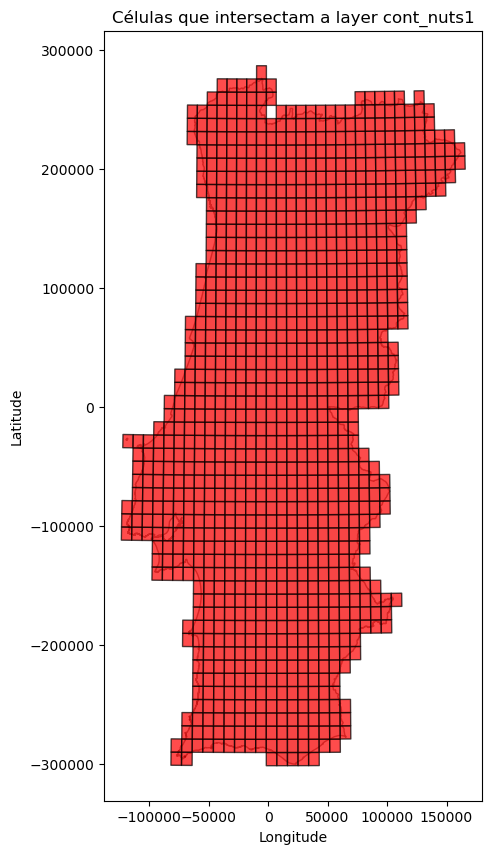

In [5]:
import matplotlib.pyplot as plt

# Plotar a layer do GPKG por trás para referência
fig, ax = plt.subplots(figsize=(10, 10))
nuts1.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plotar apenas as células que intersectam
gdf_intersect.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

ax.set_title("Células que intersectam a layer cont_nuts1")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


In [7]:
# Guardar como GeoPackage
output_fp = "Data\Portugal_cells.gpkg"
gdf_intersect.to_file(output_fp, layer="Portugal_cells", driver="GPKG")

print(f"Ficheiro guardado em: {output_fp}")

Ficheiro guardado em: Data\Portugal_cells.gpkg
